In [1]:
"""
Diffusion modèle de Vasicek
"""
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import estim_param_toolbox as EPT
import sys
from matplotlib.pyplot import figure
#syntaxe module : appeler une fonction du module EPT : EPT.creation_rate_previous(arguments)

In [2]:
#Données issues des documents excel 

Euribor = pd.read_excel ("EUR3M.xlsx")


Euribor=Euribor.reindex(index=Euribor.index[::-1])
Euribor=Euribor[1:]  #on enlève le premier jour car pas de données CAC correspondantes
Euribor.reset_index(drop=True, inplace=True)


Dates_Euribor = Euribor["Date"]
Rate_past = Euribor["Last Price"]

In [3]:
Euribor

,Date,Last Price
0,2001-01-19,4.763
1,2001-01-22,4.757
2,2001-01-23,4.756
3,2001-01-24,4.767
4,2001-01-25,4.768
...,...,...
5368,2022-01-10,-0.570
5369,2022-01-11,-0.564
5370,2022-01-12,-0.563
5371,2022-01-13,-0.563


In [4]:
Rate_past.describe()

count    5373.000000
mean        1.336896
std         1.706629
min        -0.605000
25%        -0.299000
50%         0.750000
75%         2.503000
max         5.393000
Name: Last Price, dtype: float64

In [5]:
#Paramètre schéma
jours_par_an = 260
pas = 1/jours_par_an #pas de la discrétisation temporel (1 jour)

# Paramètres du modèle de Vasicek issus autre doc "calibration"
lambd, mu, sigma = EPT.estimations_parametres_regression(Euribor,pas,1)



Estimation des paramètres par régression
a :  0.9997143520952433
b :  -0.0006103850662264598
lambda :  0.07427906457146383
mu :  -2.1368441919653645
sigma :  0.19978545427359748



# Brownien

In [6]:
def brownian(N, cov, seed, pas):
    np.random.seed(seed)
    sigma=np.array([[pas, np.sqrt(pas)*cov], [np.sqrt(pas)*cov, pas]])
    L=np.linalg.cholesky(sigma)              # factorisation de Cholesky nécessaire pour simuler un vecteur gaussien",
    W_s=0
    W_r=0
    dW=np.dot(L, np.random.randn(N,2).transpose())
    W=np.zeros((N+1,2))
    W[0,0]=W_s
    W[0,1]=W_r
    W[1:,:]=np.cumsum(dW.transpose(),0)
    return W
    

def brownianToDataFrame(N, cov, seed, pas):
    Motion =pd.DataFrame(brownian(N, cov, seed, pas), columns=["W_taux", "W_equity"])
    return Motion


In [7]:
T=len(Euribor)/260
corr=0
seed=20
pas=1/260
Brownian_correlated=brownianToDataFrame(len(Euribor), corr, seed, pas)
Brownian_correlated

,W_taux,W_equity
0,0.000000,0.000000
1,0.054817,0.012147
2,0.076990,-0.133176
3,0.009712,-0.098465
4,0.067975,-0.159148
...,...,...
5369,3.487877,4.035558
5370,3.528198,4.096645
5371,3.470994,4.089212
5372,3.497263,4.139325


In [8]:
def new_brownien(corr,nb_process,nb_simulations,nb_jours,nb_jours_annuels, seed):    
    mat_correlation=(np.ones((2,2))*corr)
    np.fill_diagonal(mat_correlation,1)
    np.random.seed(seed)
    epsilon_it = np.random.multivariate_normal([0]*nb_process, mat_correlation, (nb_jours-1,nb_simulations)).T /np.sqrt(nb_jours_annuels)

    simulations = []

    for i in range(nb_process):
        #je commence mon brownien par un 0
        W_it = np.insert(epsilon_it[i],0,np.repeat(0,nb_simulations), axis = 1)
        W_it = np.cumsum(W_it, axis=1)
        simulations.append(W_it)
    Brownian_taux = simulations[0].T
    Brownian_Equity = simulations[1].T
    plt.plot(Brownian_taux)
    plt.title('W_taux')
    plt.show()
    plt.plot(Brownian_Equity)
    
    plt.title('W_Equity')
    plt.show()
    return Brownian_taux, Brownian_Equity

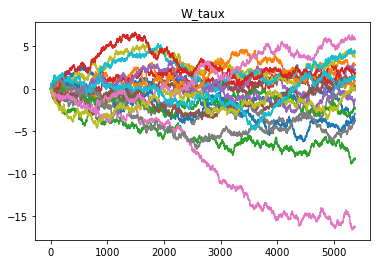

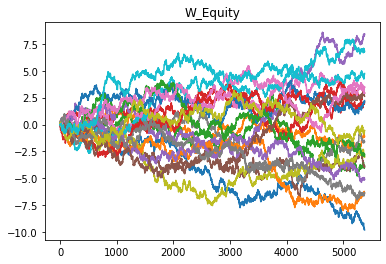

In [9]:

corr = 0
seed = 9806
nb_process = 2
nb_simulations = 20
nb_jours = len(Euribor)
nb_jours_annuels = 260
Brownian_taux, Brownian_Equity = new_brownien(corr,nb_process,nb_simulations,nb_jours,nb_jours_annuels, seed)

# Euler sans plage glissante

In [10]:
def euler3(Euribor_df, pas, Brownian):
    lambd, mu, sigma = EPT.estimations_parametres_regression(Euribor_df,pas,0)
    # brownian
    T = 1
    Euribor = Euribor_df.copy()
    N=len(Euribor)
    Euribor["Lambda"]=lambd
    Euribor["Mu"]=mu
    Euribor["Sigma"]=sigma
    Euribor["Brownien"]=Brownian["W_taux"]
    Euribor["Price_evol"]=Euribor['Last Price']
    
    for i in range(1,N):
        Euribor['Price_evol'].iloc[i] = Euribor["Price_evol"].iloc[i-1]+ Euribor["Lambda"].iloc[i]*(Euribor["Mu"].iloc[i] - Euribor["Price_evol"].iloc[i-1])*pas + Euribor["Sigma"].iloc[i]*(Euribor["Brownien"].iloc[i]-Euribor["Brownien"].iloc[i-1])
    
    return Euribor

def euler3_new(Euribor_df, pas, Browian_sim):
    lambd, mu, sigma = EPT.estimations_parametres_regression(Euribor_df,pas,0)
    # brownian
    T = 1
    Euribor = Euribor_df.copy()
    N=len(Euribor)
    Euribor=Euribor.assign(Lambda=lambd)
    Euribor=Euribor.assign(Mu=mu)
    Euribor=Euribor.assign(Sigma=sigma)
    for n_sim in tqdm(range(Browian_sim.shape[1])):
        Euribor["Price_evol"+str(n_sim)]=Euribor[ 'Last Price'].copy()
        for i in range(1,N):
            Euribor['Price_evol'+str(n_sim)].iloc[i] = Euribor["Price_evol"+str(n_sim)].iloc[i-1]+ Euribor["Lambda"].iloc[i]*(Euribor["Mu"].iloc[i] - Euribor["Price_evol"+str(n_sim)].iloc[i-1])*pas + Euribor["Sigma"].iloc[i]*(Browian_sim[i,n_sim]-Browian_sim[i-1,n_sim])
    return Euribor

Text(0.5, 1.0, 'Brownian_taux')

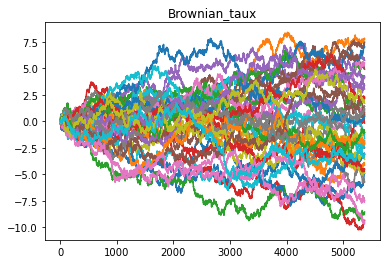

In [11]:
corr=0
pas=1/260
for i in range(20):
    Brownian_correlated=brownianToDataFrame(len(Euribor), corr, 3*i, pas)
    plt.plot(Brownian_correlated)
plt.title('Brownian_taux')

/Users/pierrepersonnat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/pierrepersonnat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/pierrepersonnat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

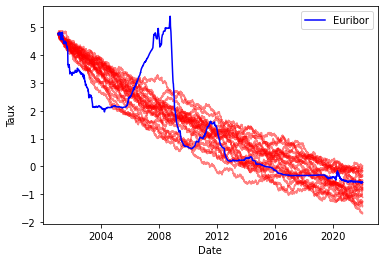

In [12]:
corr=0
pas=1/260
for i in range(20):
    Brownian_correlated=brownianToDataFrame(len(Euribor), corr, 3*i, pas)
    data1 = euler3(Euribor,pas, Brownian_correlated)
    plt.plot(data1["Date"],data1["Price_evol"], color = 'red',alpha = 0.5)
    
plt.plot(data1["Date"],data1["Last Price"],label="Euribor", color = 'blue')
plt.xlabel("Date")
plt.ylabel("Taux")
plt.legend()
plt.show() 

In [14]:
from tqdm import tqdm
data1 = euler3_new(Euribor,pas, Brownian_taux)


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


100%|██████████| 20/20 [00:00<00:00, 355.87it/s]

10.989749317832239


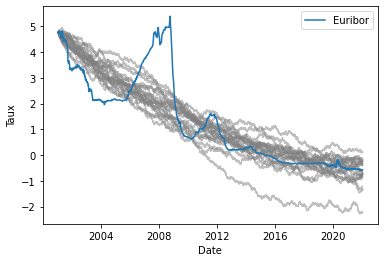

In [16]:
print(Brownian_taux.var())
for n_sim in tqdm(range(Brownian_taux.shape[1])):
    plt.plot(data1["Date"],data1["Price_evol"+str(n_sim)], color = 'grey',alpha = 0.5)
plt.plot(data1["Date"],data1["Last Price"],label="Euribor")
plt.xlabel("Date")
plt.ylabel("Taux")
plt.legend()
plt.show()

# Euler avec plage glissante

In [15]:
def euler_choix_actualisation_parametres2(Euribor_df, Brownian, duree_actualisation,pas):
    # nouveau dataframe avec les sigmas,mus....
    Euribor =  EPT.plage_glissante(duree_actualisation,Euribor_df,pas)
    T = 1
    N=len(Euribor)
    #brownien
    Euribor["Brownien"]=Brownian["W_taux"]
    Euribor["Price_evol"]=Euribor['Last Price']
    for i in range(1,N):
        Euribor['Price_evol'].iloc[i] = Euribor["Price_evol"].iloc[i-1]+ Euribor["Lambda_reg"].iloc[i]*(Euribor["Mu_reg"].iloc[i] - Euribor["Price_evol"].iloc[i-1])*pas + Euribor["Sigma_reg"].iloc[i]*(Euribor["Brownien"].iloc[i]-Euribor["Brownien"].iloc[i-1])
    
    return Euribor
def euler_choix_actualisation_parametres2_new(Euribor_df, Browian_sim, duree_actualisation,pas):
    # nouveau dataframe avec les sigmas,mus....
    Euribor=  EPT.plage_glissante(duree_actualisation,Euribor_df,pas)
    T = 1
    N=len(Euribor)
    print(N)
    #brownien
    for n_sim in tqdm(range(Browian_sim.shape[1])):
        Euribor["Price_evol"+str(n_sim)]=Euribor[ 'Last Price'].copy()
        for i in range(1,N):
            Euribor['Price_evol'+str(n_sim)].iloc[i] = Euribor["Price_evol"+str(n_sim)].iloc[i-1]+ Euribor["Lambda_reg"].iloc[i]*(Euribor["Mu_reg"].iloc[i] - Euribor["Price_evol"+str(n_sim)].iloc[i-1])*pas + Euribor["Sigma_reg"].iloc[i]*(Browian_sim[i,n_sim]-Browian_sim[i-1,n_sim])
    return Euribor

In [16]:
list_rate_diffused= []
corr=0
pas=1/260
for i in range(20):
    Brownian_correlated=brownianToDataFrame(len(Euribor), corr, 3*i, pas)
    list_rate_diffused.append(euler_choix_actualisation_parametres2(Euribor, Brownian_correlated, 90,pas))  # 90 jours : fenêtre de 3 mois

D:\Users\imane.haoudi\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


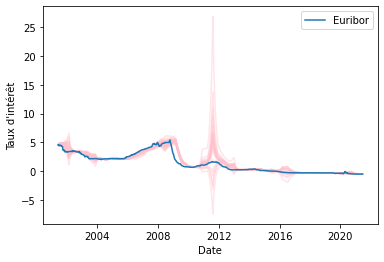

In [17]:
for i in range(20):
    plt.plot(list_rate_diffused[i]["Date"],list_rate_diffused[i]["Price_evol"], color = 'pink',alpha = 0.4)
    
plt.plot(list_rate_diffused[0]["Date"],list_rate_diffused[0]["Last Price"],label="Euribor")
plt.xlabel("Date")
plt.ylabel("Taux d'intérêt")
plt.legend()
plt.show()

In [18]:
pas=1/260
rate_df_sim = euler_choix_actualisation_parametres2_new(Euribor,Brownian_taux,90,pas)


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

5130


D:\Users\imane.haoudi\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:01<00:00,  3.10s/it]


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.04it/s]


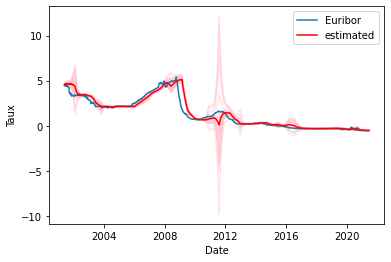

In [19]:
for n_sim in tqdm(range(Brownian_taux.shape[1])):
    plt.plot(rate_df_sim["Date"],rate_df_sim["Price_evol"+str(n_sim)], color = 'pink',alpha = 0.4)
plt.plot(rate_df_sim["Date"],rate_df_sim["Last Price"],label="Euribor")
plt.plot(rate_df_sim["Date"],rate_df_sim.iloc[:,8:].mean(axis=1), label = 'estimated', color = 'red')
plt.xlabel("Date")
plt.ylabel("Taux")
plt.legend()
plt.show()

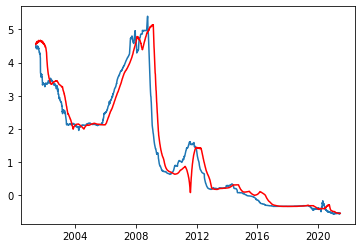

In [20]:
plt.plot(rate_df_sim["Date"],rate_df_sim["Last Price"],label="Euribor")
plt.plot(rate_df_sim["Date"],rate_df_sim.iloc[:,8:].mean(axis=1), label = 'estimated', color = 'red')

# EQUITY

In [19]:
cac40 = pd.read_excel ("cac40.xlsx")


cac40=cac40.reindex(index=cac40.index[::-1])
cac40.reset_index(drop=True, inplace=True)


cac40
Euribor

,Date,Last Price
0,2001-01-19,4.763
1,2001-01-22,4.757
2,2001-01-23,4.756
3,2001-01-24,4.767
4,2001-01-25,4.768
...,...,...
5368,2022-01-10,-0.570
5369,2022-01-11,-0.564
5370,2022-01-12,-0.563
5371,2022-01-13,-0.563


In [20]:
def euler_equity(Equity_df, Brownian, duree_actualisation, pas):
    # nouveau dataframe avec les sigmas,mus....
    Equity=  EPT.plage_glissante_equity(duree_actualisation, Equity_df, pas)  # faire plage glissante equity qui crée colonne equity["sigma_s"]
    T = 1
    N=len(Equity)
    # Brownien Equity
    Equity["Brownien"]=Brownian["W_equity"]
    Equity["Price_evol"]=Equity['CAC Index - Last Price'] #créer nouvelle colonne, on conservera uniquement S_0
    for i in range(1,N):
        Equity['Price_evol'].iloc[i] = Equity["Price_evol"].iloc[i-1]*(np.exp((Equity["Mu"].iloc[i] - 0.5*(Equity["Sigma"].iloc[i]**2)) * pas + Equity["Sigma"].iloc[i]*(Equity["Brownien"].iloc[i]-Equity["Brownien"].iloc[i-1])))
    return Equity 

def euler_equity_new(Equity_df, Browian_sim, duree_actualisation, pas):
    # nouveau dataframe avec les sigmas,mus....
    Equity=  EPT.plage_glissante_equity(duree_actualisation, Equity_df, pas)  # faire plage glissante equity qui crée colonne equity["sigma_s"]
    T = 1
    N=len(Equity)
    # Brownien Equity
    for n_sim in tqdm(range(Browian_sim.shape[1])):
        Equity["Price_evol"+str(n_sim)]=Equity[ 'CAC Index - Last Price'].copy()
        for i in range(1,N):
            Equity['Price_evol'+str(n_sim)].iloc[i] = Equity["Price_evol"+str(n_sim)].iloc[i-1]*(np.exp((Equity["Mu"].iloc[i] - 0.5*(Equity["Sigma"].iloc[i]**2)) * pas + Equity["Sigma"].iloc[i]*(Browian_sim[i,n_sim]-Browian_sim[i-1,n_sim])))
    return Equity 

In [21]:
corr=0
pas=1/260
list_Equity = []
for i in range(20):
    Brownian_correlated=brownianToDataFrame(len(Euribor), corr, 3*i, pas)
    list_Equity.append(euler_equity(cac40, Brownian_correlated , 90, 1/260) ) # 90 jours : fenêtre de 3 mois


/Users/pierrepersonnat/Documents/GitHub/StatApp/estim_param_toolbox.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CAC_data['Log_Ratio'] = np.log(a/b)
/Users/pierrepersonnat/Documents/GitHub/StatApp/estim_param_toolbox.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CAC_data['Log_Ratio'].dropna(inplace=True)
/Users/pierrepersonnat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

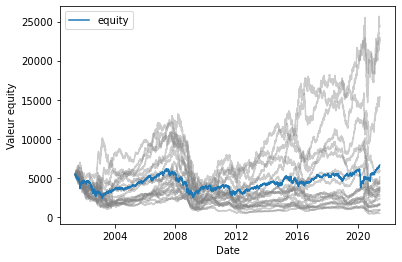

In [24]:
for i in range(20):
    plt.plot(list_Equity[i]["Date"],list_Equity[i]["Price_evol"], color = 'grey', alpha = 0.4)

plt.plot(list_Equity[0]["Date"],list_Equity[0]["CAC Index - Last Price"],label="equity")

plt.xlabel("Date")
plt.ylabel("Valeur equity")
plt.legend()
plt.show()

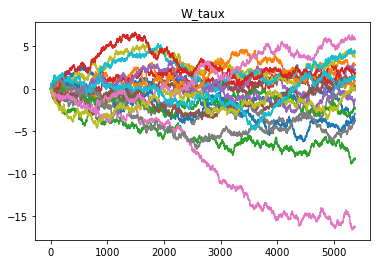

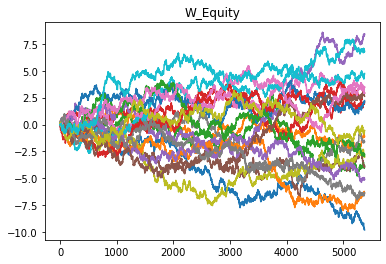

/Users/pierrepersonnat/Documents/GitHub/StatApp/estim_param_toolbox.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CAC_data['Log_Ratio'] = np.log(a/b)
/Users/pierrepersonnat/Documents/GitHub/StatApp/estim_param_toolbox.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CAC_data['Log_Ratio'].dropna(inplace=True)
  0%|          | 0/20 [00:00<?, ?it/s]/Users/pierrepersonnat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

In [22]:

corr = 0
seed = 9806
nb_process = 2
nb_simulations = 20
nb_jours = len(Euribor)
nb_jours_annuels = 260
Brownian_taux, Brownian_Equity = new_brownien(corr,nb_process,nb_simulations,nb_jours,nb_jours_annuels, seed)

pas=1/260
equity_df_sim = euler_equity_new(cac40,Brownian_Equity,90,pas)

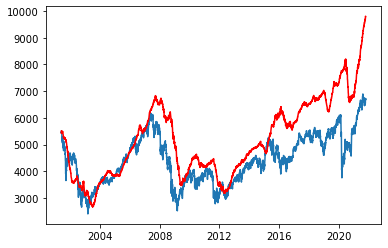

In [23]:
plt.plot(equity_df_sim["Date"],equity_df_sim["CAC Index - Last Price"],label="equity")

plt.plot(equity_df_sim["Date"],equity_df_sim.iloc[:,8:].mean(axis=1), label = 'estimated', color = 'red')

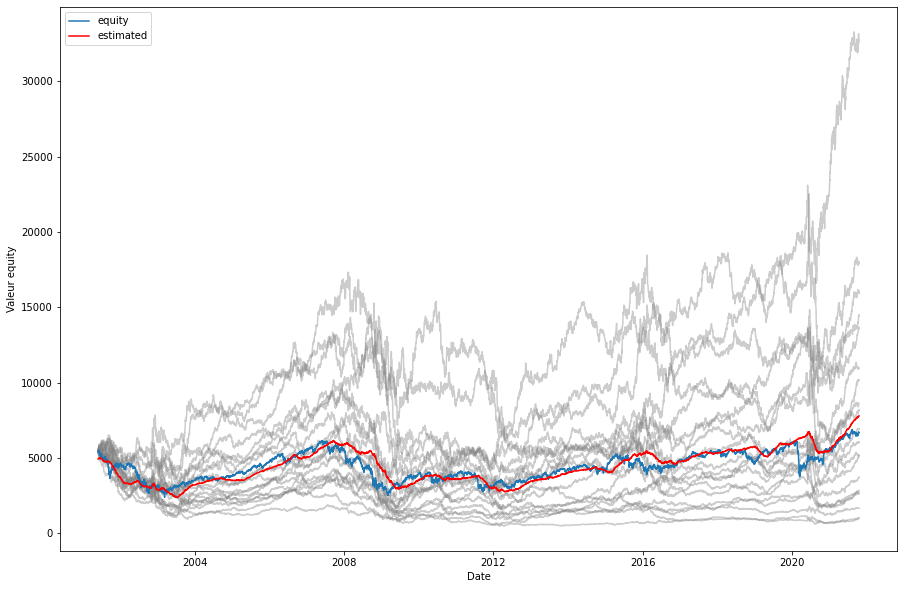

In [28]:
plt.figure(figsize = (15,10))
for i in range(20):
    plt.plot(equity_df_sim["Date"],equity_df_sim["Price_evol"+str(i)], color = 'grey', alpha = 0.4)

plt.plot(equity_df_sim["Date"],equity_df_sim["CAC Index - Last Price"],label="equity")

plt.plot(equity_df_sim["Date"],equity_df_sim.iloc[:,2:].mean(axis=1), label = 'estimated', color = 'red')

plt.xlabel("Date")
plt.ylabel("Valeur equity")
plt.legend()
plt.show()